## Scenario: The goal is to predict whether or not the auction will be competitive.

## Data: The file eBayAuctions.csv contains information on 1972 auctions transacted on eBay.com during May–June 2004. The goal is to use these data to build a model that will distinguish competitive auctions from noncompetitive ones. A competitive auction is defined as an auction with at least two bids placed on the item being auctioned. The data include variables that describe the item (auction category), the seller (his or her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day of week of auction close). In addition, we have the price at which the auction closed.

## Data preprocessing: Load the data and convert categorical variables to dummies. Split the data into training (60%) and validation (40%) sets (use random_state=1).

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

no display found. Using non-interactive Agg backend


### Question 1 (5 points) Run a logistic regression with all predictors. Interpret the coefficients of the predictors. Look at the coefficients and identify categories that are most and least competitive.

In [2]:
eBayAuctions = pd.read_csv('dmba\eBayAuctions.csv')
eBayAuctions.tail(15)


,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
1957,Electronics,US,2358,5,Mon,202.50,199.99,1
1958,Books,US,155,7,Mon,421.00,99.99,1
1959,Automotive,US,2992,5,Sun,229.50,199.00,1
1960,Collectibles,US,862,5,Sat,219.00,219.00,0
1961,Automotive,US,374,7,Mon,545.00,100.00,1
1962,Automotive,US,0,10,Sun,590.00,99.00,1
1963,Automotive,EUR,4,10,Sun,780.89,122.97,1
1964,SportingGoods,US,1,7,Fri,417.99,200.00,1
1965,Automotive,US,97,3,Fri,290.00,290.00,0
1966,Automotive,US,142,7,Sat,521.55,200.00,1


In [3]:
eBayAuctions = pd.get_dummies(eBayAuctions, drop_first=True)

y = eBayAuctions['Competitive?']
X = eBayAuctions.drop(columns=['Competitive?'])

eBayAuctions = pd.get_dummies(eBayAuctions, drop_first=True)

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.6480357860302982
             sellerRating  Duration  ClosePrice  OpenPrice  \
coefficient     -0.000043   0.02479    0.089703  -0.106879   

             Category_Automotive  Category_Books  \
coefficient             -0.41175        0.399529   

             Category_Business/Industrial  Category_Clothing/Accessories  \
coefficient                      0.969777                      -1.180215   

             Category_Coins/Stamps  Category_Collectibles  ...  \
coefficient              -1.608725               0.026304  ...   

             Category_SportingGoods  Category_Toys/Hobbies  currency_GBP  \
coefficient                0.003268               0.328014      1.339327   

             currency_US  endDay_Mon  endDay_Sat  endDay_Sun  endDay_Thu  \
coefficient     0.561646    0.461497   -0.596305   -0.388919    -0.21247   

             endDay_Tue  endDay_Wed  
coefficient   -0.205604   -0.599631  

[1 rows x 29 columns]

AIC 1198.247029956375


### Question 2 (3 points) Use your regression from Question 1 to make prediction in your validation set. How accurate are your predictions? Produce a confusion matrix on your validation set.

In [4]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.7819)

       Prediction
Actual   0   1
     0 447 106
     1 152 478
Confusion Matrix (Accuracy 0.7529)

       Prediction
Actual   0   1
     0 280  73
     1 122 314


### Question 3 (5 points) If we want to predict at the start of an auction whether it will be competitive, we cannot use the information on the closing price. Run a logistic model with all predictors as above, excluding closing price. How does this model compare to the full model with respect to accurate prediction? Produce a confusion matrix, lift chart, and decile chart on the validation set using your model, excluding closing price.

In [5]:
eBayAuctions = pd.read_csv('dmba\eBayAuctions.csv')

eBayAuctions = pd.get_dummies(eBayAuctions, drop_first=True)

y = eBayAuctions['Competitive?']
X = eBayAuctions.drop(columns=['ClosePrice', 'Competitive?'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  0.524977416568871
             sellerRating  Duration  OpenPrice  Category_Automotive  \
coefficient     -0.000046  -0.04087  -0.004623            -0.709739   

             Category_Books  Category_Business/Industrial  \
coefficient        -0.14076                       1.50015   

             Category_Clothing/Accessories  Category_Coins/Stamps  \
coefficient                      -0.377092              -2.123841   

             Category_Collectibles  Category_Computer  ...  \
coefficient               0.116217           0.328619  ...   

             Category_SportingGoods  Category_Toys/Hobbies  currency_GBP  \
coefficient                1.201199               0.125088      1.454812   

             currency_US  endDay_Mon  endDay_Sat  endDay_Sun  endDay_Thu  \
coefficient     0.053287    0.865671   -0.395339   -0.232491   -0.490532   

             endDay_Tue  endDay_Wed  
coefficient     -0.0137   -0.240777  

[1 rows x 28 columns]

AIC 1503.9261970768403


#### Confusion Matrix on the validation set using your model, excluding closing price

In [6]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.6754)

       Prediction
Actual   0   1
     0 343 210
     1 174 456
Confusion Matrix (Accuracy 0.6350)

       Prediction
Actual   0   1
     0 207 146
     1 142 294


### Lift chart and Decile Chart on the validation set using your model, excluding closing price

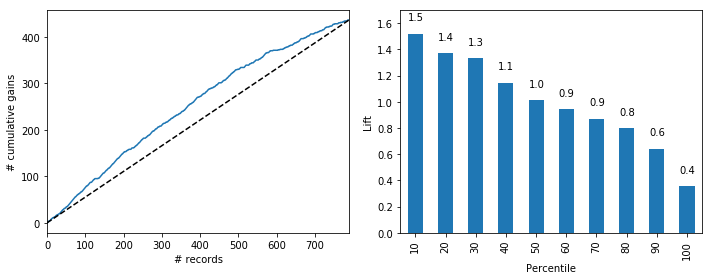

In [7]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

#### Compared to the full model with respect to accurate prediction, the accuracy of both the training set and validation set for the model excluding closing price, 0.6754 and 0.6350 respectively, are lower than the accuracy of the training set and validation set for the model that included closing price, 0.7819 and 0.7529 respectively.

### Question 4 (2 points) Interpret the meaning of the coefficient for closing price. Does closing price have a practical significance?

#### The coefficient of 0.089703 for the closing price implies that the closing price variable contributes positively to the response (i.e. competitiveness).  However, the fact that the closing price is not known at the start of the auction means we don't know what the closing prices will be and can not use closing price as a variable for our model to predict the competitiveness of our auction.  Therefore, there is no practical significance of closing price.